# Surface Crack detection

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import shutil, os, glob, random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import splitfolders
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import torch.nn.functional as F
from tqdm.auto import tqdm
from torch.autograd import Variable

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# gpu연산 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'{device} is available')
print("cuda number : ", os.environ["CUDA_VISIBLE_DEVICES"])
print("cuda device : ", torch.cuda.device_count())

cuda is available
cuda number :  1
cuda device :  1


## 1. dataset

(227, 227, 3)


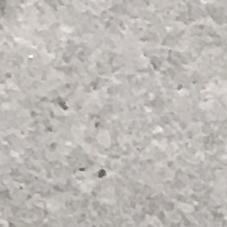

In [3]:
ex_image = '/home/sona/surface/data/negative/00003.jpg'

print(np.array(Image.open(ex_image)).shape)
Image.open(ex_image)

## 2. preprocessing

In [4]:
# splitfolders.ratio('/home/sona/surface/data', output='split', seed=111, ratio=(0.8, 0.1, 0.1))

In [5]:
def get_data():
    data_dir = './split/'
    
    transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.ToTensor(), # 차원을 (w, h, c) -> (c, w, h), array->tensor, min-max scale
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                    ])
    
    train_set = datasets.ImageFolder(data_dir + '/train', transform=transform)
    val_set = datasets.ImageFolder(data_dir + '/val', transform=transform)
    test_set = datasets.ImageFolder(data_dir + '/test', transform=transform)
    
    train = DataLoader(train_set, batch_size=64, shuffle=True)
    val = DataLoader(val_set, batch_size=64, shuffle=True)
    test = DataLoader(test_set, batch_size=64, shuffle=True)
    
    return train, val, test

In [6]:
def check_image(split):
    for data in split:
        img, label = data
        plt.imshow(torchvision.utils.make_grid(img, normalize=True).permute(1,2,0))
        plt.show()
        break

## 3. model

https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/



In [7]:
# 크기 확인용
# class CNet(nn.Module):   
#     def __init__(self):
#         super(CNet, self).__init__()
        
#         self.conv1 = Conv2d(3, 5, kernel_size=5, stride=1, padding=1)
#         self.batch1 = BatchNorm2d(5)
#         self.relu1 = ReLU()
#         self.maxp1 = MaxPool2d(kernel_size=2, stride=2)
        
#         self.conv2 = Conv2d(5, 10, kernel_size=5, stride=1, padding=1)
#         self.batch2 = BatchNorm2d(10)
#         self.relu2 = ReLU()
#         self.maxp2 = MaxPool2d(kernel_size=2, stride=2)

#         self.linear = Linear(10*54*54, 10)

#     # Defining the forward pass    
#     def forward(self, x):
#         print(x.size())
#         x = self.conv1(x)
#         print(x.size())
        
#         x = self.batch1(x)
#         print(x.size())
        
#         x = self.relu1(x)
#         print(x.size())
        
#         x = self.maxp1(x)
#         print(x.size())
        
#         x = self.conv2(x)
#         print(x.size())
        
#         x = self.batch2(x)
#         print(x.size())
        
#         x = self.relu2(x)
#         print(x.size())
        
#         x = self.maxp2(x)
#         print(x.size())
        
#         x = x.view(x.size(0), -1) # like flatten
#         print(x.size())
        
#         x = self.linear(x)
#         print(x.size())
        
#         return x

In [40]:
class CNet(nn.Module):   
    def __init__(self):
        super(CNet, self).__init__()
        
        self.cnn_layers = nn.Sequential(
            Conv2d(3, 5, kernel_size=5, stride=1, padding=0),
            BatchNorm2d(5),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
            
            Conv2d(5, 10, kernel_size=5, stride=1, padding=0),
            BatchNorm2d(10),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            Linear(10*54*54, 10)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1) # like flatten
        x = self.linear_layers(x)
        
        return x

In [29]:
def model_train(n_epoch):
    model.train()  # 학습을 위함
    train_losses = []
    
    for epoch in tqdm(range(n_epoch)):

        for index, (images, target) in enumerate(train):
            X_train, y_train = Variable(images), Variable(target)
            X_train, y_train = X_train.to(device), y_train.to(device)
            
            # 기울기 초기화
            optimizer.zero_grad()

            # prediction
            output_train = model(X_train)

            # loss
            loss_train = criterion(output_train, y_train)
            
            # update
            loss_train.backward()
            optimizer.step()
            
            train_losses.append(loss_train.item())
        print('Epoch : ', epoch, '\t loss_train: ', loss_train)
                    
    return train_losses

In [37]:
def model_val(n_epoch):
    model.eval()
    val_losses = []
    
    with torch.no_grad():
        for epoch in tqdm(range(n_epoch)):

            for index, (images, target) in enumerate(val):
                X_val, y_val = Variable(images), Variable(target)
                X_val, y_val = X_val.to(device), y_val.to(device)

                # 기울기 초기화 - val에서는 optimizer를 안씀 (optimizer는 update할 때 사용)
                # optimizer.zero_grad()

                # prediction
                output_val = model(X_val)

                # loss
                loss_val = criterion(output_val, y_val)

    #             # update - val 평가를 위해 업데이트를 하지 않음
    #             loss_val.backward()
    #             optimizer.step()

                val_losses.append(loss_val.item())    
        print('Epoch : ', epoch, '\t loss_val: ', loss_val)
            
    return val_losses

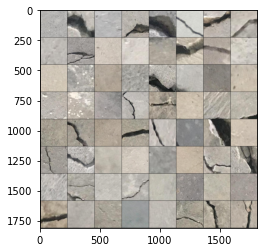

In [38]:
# preprocessing
train, val, test = get_data()
check_image(val)

In [39]:
# model
model = CNet().to(device)
criterion = CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print(model)

CNet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=29160, out_features=10, bias=True)
  )
)


In [33]:
# train
n_epoch = 10
train_losses = model_train(n_epoch)

  0%|          | 0/10 [00:00<?, ?it/s]

> /tmp/ipykernel_914777/288370868.py(26)forward()
     24         import pdb
     25         pdb.set_trace()
---> 26         x = self.cnn_layers(x)
     27         x = x.view(x.size(0), -1) # like flatten
     28         x = self.linear_layers(x)



ipdb>  x.shape


torch.Size([64, 5, 220, 220])


ipdb>  n


> /tmp/ipykernel_914777/288370868.py(27)forward()
     25         pdb.set_trace()
     26         x = self.cnn_layers(x)
---> 27         x = x.view(x.size(0), -1) # like flatten
     28         x = self.linear_layers(x)
     29 



ipdb>  x.shape


torch.Size([64, 10, 53, 53])


ipdb>  q


BdbQuit: 

In [14]:
val_losses = model_val(n_epoch)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch :  0 	 loss_val:  tensor(0.1120, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  1 	 loss_val:  tensor(0.1204, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  2 	 loss_val:  tensor(0.2015, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss_val:  tensor(0.1101, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  4 	 loss_val:  tensor(0.2857, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss_val:  tensor(0.3267, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  6 	 loss_val:  tensor(0.1630, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  7 	 loss_val:  tensor(0.1020, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  8 	 loss_val:  tensor(0.0367, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch :  9 	 loss_val:  tensor(0.1147, device='cuda:0', grad_fn=<NllLossBackward0>)


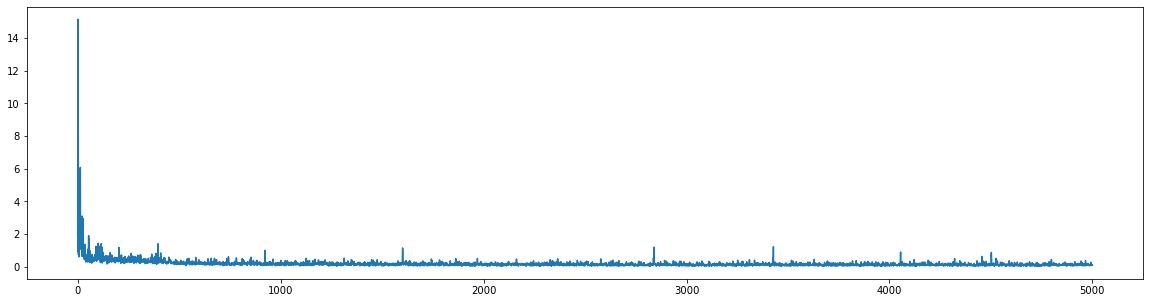

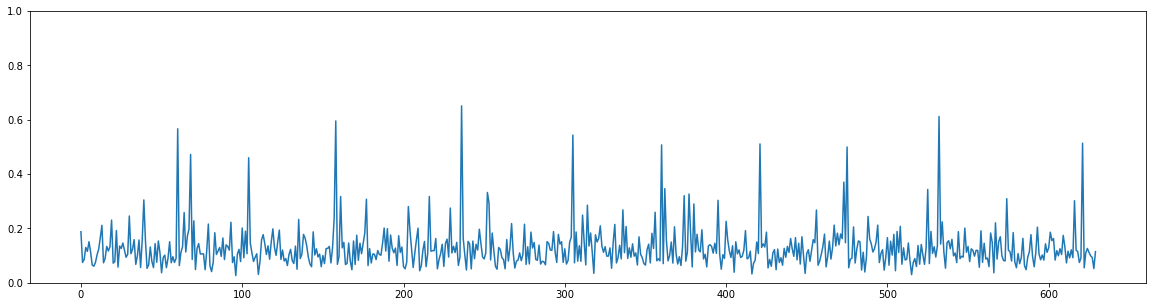

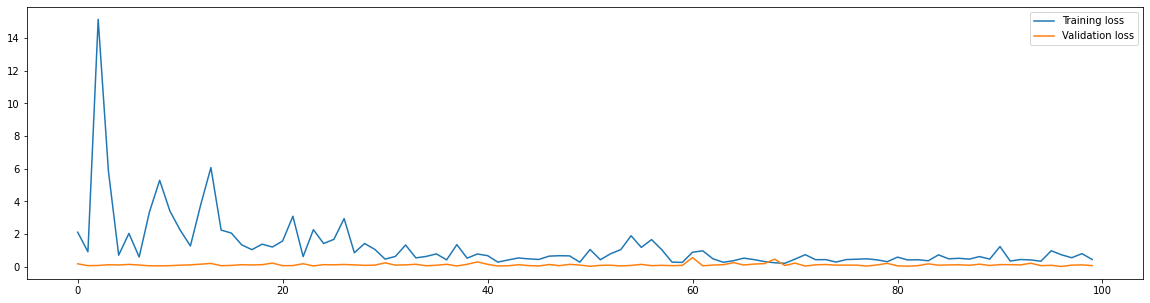

In [34]:
plt.figure(figsize=(20,5))
plt.plot(np.array(train_losses), label='Training loss')

plt.figure(figsize=(20,5))
plt.plot(np.array(val_losses), label='Validation loss')
plt.ylim(0,1)

plt.figure(figsize=(20,5))
plt.plot(np.array(train_losses[:100]), label='Training loss')
plt.plot(np.array(val_losses[:100]), label='Validation loss')
plt.legend()
plt.show()

# 모델 저장

In [16]:
torch.save(model, 'cnn_model.pt')

# 모델 로드 후 test

In [20]:
model = torch.load('./cnn_model.pt')
model = model.to(device)

In [22]:
model.eval()  # test case 학습 방지를 위함
test_loss = 0
correct = 0
test_losses = []
Accuracy = []

with torch.no_grad():
    for images, target in tqdm(test):
        images, target = images.to(device), target.to(device)
        
        output = model(images)
        test_loss = criterion(output, target).item() # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test.dataset)
        test_losses.append(test_loss)
        Accuracy.append(accuracy)
        
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct,
                                                                             len(test.dataset),
                                                                             accuracy))

  0%|          | 0/63 [00:00<?, ?it/s]


Test set: Average loss: 0.0793, Accuracy: 3843/4000 (96%)



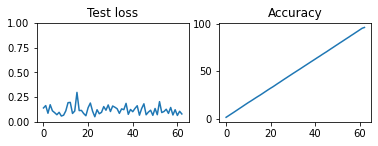

In [47]:
plt.subplot(221)
plt.title("Test loss")
plt.ylim(0,1)
plt.plot(test_losses, label='Test loss')

plt.subplot(222)
plt.title("Accuracy")
plt.plot(Accuracy, label='Accuracy')
plt.show()